In [1]:
from icecap.infrastructure.memory_manager import get_memory_manager
from icecap.infrastructure.process import get_wow_process_id
from icecap.infrastructure.driver import GameDriver
from icecap.infrastructure.repository import PlayerRepository, UnitRepository
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib
import IPython

%matplotlib widget

In [2]:
memory_manager = get_memory_manager(get_wow_process_id())
driver = GameDriver(memory_manager)
player_repository = PlayerRepository(driver)
unit_repository = UnitRepository(driver)

In [3]:
local_player = player_repository.get_local_player()
units = list(unit_repository.yield_units())

In [4]:
# Get initial player position
local_player = player_repository.refresh_player(local_player)
initial_player_position = local_player.position
print(f"Initial player position: {initial_player_position}")

# Get initial unit positions
units = list(player_repository.yield_players())
print(f"Found {len(units)} units")


Initial player position: Position(x=640.144775390625, y=5908.09521484375, z=645.3965454101562, rotation=5.596546173095703)
Found 102 units


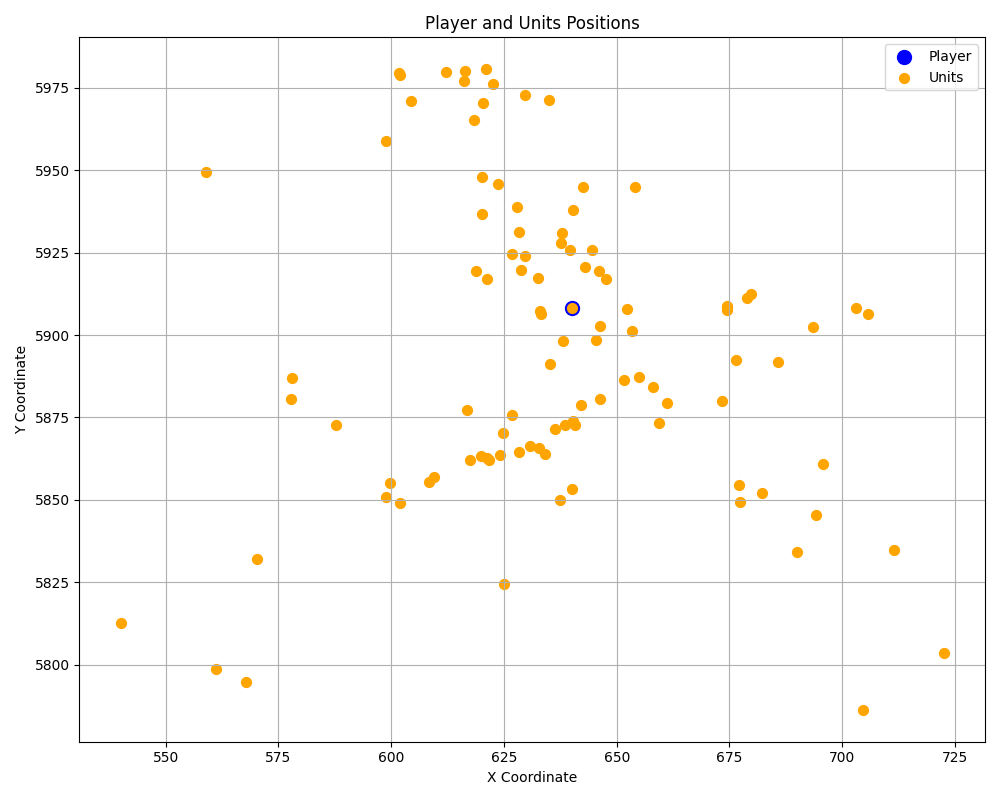

In [5]:
# Set up the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
ax.set_title('Player and Units Positions')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.grid(True)

# Initialize player position
player_x = initial_player_position.x
player_y = initial_player_position.y

# Create a scatter plot for the player position (blue)
player_scatter = ax.scatter([player_x], [player_y], c='blue', s=100, label='Player')

# Create a scatter plot for the unit positions (orange)
unit_x = [unit.position.x for unit in units if hasattr(unit, 'position')]
unit_y = [unit.position.y for unit in units if hasattr(unit, 'position')]
units_scatter = ax.scatter(unit_x, unit_y, c='orange', s=50, label='Units')

# Add legend
ax.legend()

# Function to update the plot
def update_plot(frame):
    # Refresh player and get new position
    refreshed_player = player_repository.refresh_player(local_player)
    player_position = refreshed_player.position

    # Refresh units and get their positions
    refreshed_units = list(player_repository.yield_players())

    # Update player scatter
    player_scatter.set_offsets(np.array([[player_position.x, player_position.y]]))

    # Update units scatter
    unit_positions = np.array([[unit.position.x, unit.position.y] for unit in refreshed_units if hasattr(unit, 'position')])
    if len(unit_positions) > 0:
        units_scatter.set_offsets(unit_positions)

    # Adjust plot limits if necessary
    ax.relim()
    ax.autoscale_view()

    return player_scatter, units_scatter

# Using a generator function for frames to avoid warnings about infinite animations
def frames_generator():
    frame_number = 0
    while True:
        yield frame_number
        frame_number += 1

# Create animation that updates every 100ms
ani = FuncAnimation(fig, update_plot, interval=100, frames=frames_generator(), save_count=100, blit=False)

# Keep a reference to the animation to prevent it from being garbage collected
plt.tight_layout()